In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
# Load the preprocessed weather data from the CSV file
df = pd.read_csv("processed_weather_data_6years.csv")

# Features (X) and multiple target variables (y)
x = df[['temp', 'pressure', 'humidity', 'clouds', 'wind_speed', 'wind_deg', 
        'temp_lag_1', 'pressure_lag_1', 'humidity_lag_1', 'clouds_lag_1', 
        'wind_speed_lag_1', 'wind_deg_lag_1', 'rolling_avg_3hr', 'temp_rolling_avg', 
        'humidity_rolling_avg', 'wind_speed_rolling_avg', 'hour_of_day', 'day_of_week', 
        'is_weekend', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'elapsed_time_of_day', 
        'month_of_year', 'day_of_year', 'hourly_avg_temp', 'hourly_temp_max', 'hourly_temp_min']].values

y = df[['target_temp', 'target_pressure', 'target_humidity', 'target_clouds', 
        'target_wind_speed', 'target_wind_deg']].values


In [32]:
# Normalize the data (important for neural networks)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [53]:
import joblib

# 3. Save the scalers after fitting them
joblib.dump(scaler_X, 'scaler_X.pkl')  # Save feature scaler
joblib.dump(scaler_y, 'scaler_y.pkl')  # Save target scaler

['scaler_y.pkl']

In [33]:
# Split the data chronologically - 80% past (training) and 20% future (testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [34]:
# Reshape the data to be 3D (samples, time steps, features) for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [35]:
# Initialize the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(50))
model.add(Dense(6))  # Number of output features (6 targets)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5176 - val_loss: 0.4360
Epoch 2/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4363 - val_loss: 0.4313
Epoch 3/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4256 - val_loss: 0.4345
Epoch 4/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4212 - val_loss: 0.4328
Epoch 5/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4159 - val_loss: 0.4335
Epoch 6/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4111 - val_loss: 0.4338
Epoch 7/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4107 - val_loss: 0.4384
Epoch 8/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4071 - val_loss: 0.4357
Epoch 9/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4019 - val_loss: 0.4337
Epoch 10/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4027 - val_loss: 0.4489
Epoch 11/20
1318/1318 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3997 - val_loss: 0.4435
Epoch 12/20
1318/1318 ━━━━━━━━

In [37]:
# Make predictions on the test set
y_pred_scaled = model.predict(X_test)

330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


In [38]:
# Inverse transform the scaled predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

In [39]:
# Evaluate the model for each target variable
mse = mean_squared_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

In [41]:
# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 1951.2034696416115
R² Score: 0.5486219996186977


In [42]:
# Save the current model
model.save('weather_forecast_model_v1.keras')

In [43]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Initialize the model
model2 = Sequential()
model2.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))  # Adding Dropout layer for regularization
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(50))
model2.add(Dense(6))  # Number of output features (6 targets)

# Compile the model with Adam optimizer and smaller learning rate
optimizer2 = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer2, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


659/659 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8735 - val_loss: 0.5570
Epoch 2/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5511 - val_loss: 0.4879
Epoch 3/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5060 - val_loss: 0.4721
Epoch 4/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4927 - val_loss: 0.4630
Epoch 5/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4827 - val_loss: 0.4579
Epoch 6/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4770 - val_loss: 0.4557
Epoch 7/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4759 - val_loss: 0.4510
Epoch 8/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4679 - val_loss: 0.4481
Epoch 9/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4658 - val_loss: 0.4457
Epoch 10/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4624 - val_loss: 0.4448
Epoch 11/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4603 - val_loss: 0.4437
Epoch 12/50
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

In [44]:
# Evaluate the model
y_pred2 = model2.predict(X_test)

330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


In [45]:
# Inverse transform the scaled predictions and actual values
y_pred2 = scaler_y.inverse_transform(y_pred2)
y_test_actual = scaler_y.inverse_transform(y_test)

In [46]:
# Evaluate the model for each target variable
mse = mean_squared_error(y_test_actual, y_pred2)
r2 = r2_score(y_test_actual, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 1749.8739411325043
R² Score: 0.5486219996186977


In [47]:
# Save the current model
model.save('weather_forecast_model_v2.keras')

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Initialize the LSTM model
model3 = Sequential()

# Add LSTM layer
model3.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

# Add Dropout layer for regularization
model3.add(Dropout(0.2))  # Drop 20% of the neurons

# Add Dense layers
model3.add(Dense(50, activation='relu'))  # Optional: you can experiment with 32, 64, etc.

# Output layer for multiple targets
model3.add(Dense(6))  # Output layer with 6 units for your 6 targets

# Compile the model with a smaller learning rate
optimizer3 = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer3, loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model3.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Summary of the model architecture
model3.summary()

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


659/659 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7970 - val_loss: 0.5167
Epoch 2/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - loss: 0.5114 - val_loss: 0.4691
Epoch 3/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4772 - val_loss: 0.4563
Epoch 4/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4655 - val_loss: 0.4499
Epoch 5/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 0.4584 - val_loss: 0.4463
Epoch 6/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - loss: 0.4554 - val_loss: 0.4438
Epoch 7/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 0.4563 - val_loss: 0.4416
Epoch 8/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4534 - val_loss: 0.4405
Epoch 9/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4497 - val_loss: 0.4388
Epoch 10/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4465 - val_loss: 0.4370
Epoch 11/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 0.4459 - val_loss: 0.4368
Epoch 12/100
659/659 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,862 (323.68 KB)

 Trainable params: 27,620 (107.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 55,242 (215.79 KB)

In [49]:
# Evaluate the model
y_pred3 = model3.predict(X_test)

# Inverse transform the scaled predictions and actual values
y_pred3 = scaler_y.inverse_transform(y_pred3)
y_test_actual = scaler_y.inverse_transform(y_test)

330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step


In [50]:
# Evaluate the model for each target variable
mse = mean_squared_error(y_test_actual, y_pred3)
r2 = r2_score(y_test_actual, y_pred3)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 1761.1237029069205
R² Score: 0.5773494944250713


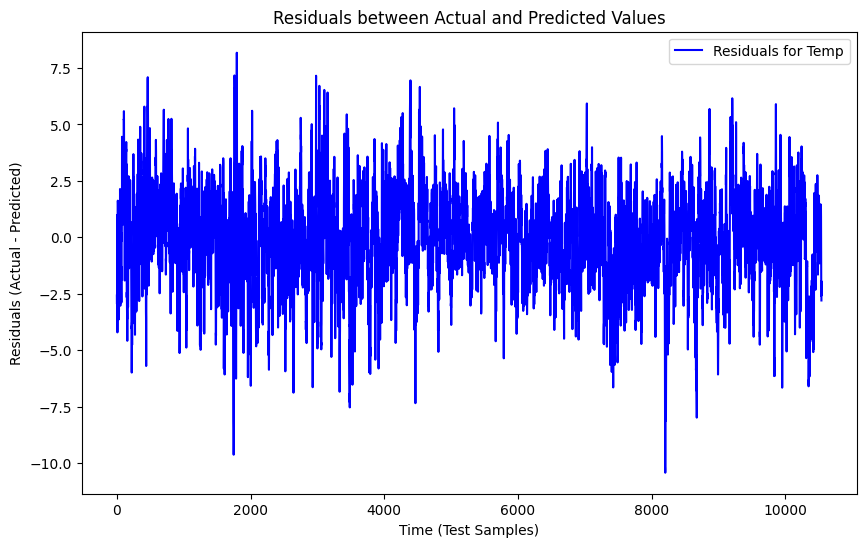

In [51]:
import matplotlib.pyplot as plt

# Calculate the residuals (differences between actual and predicted values)
residuals = y_test_actual - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals[:, 0], label="Residuals for Temp", color='blue')
plt.title("Residuals between Actual and Predicted Values")
plt.xlabel("Time (Test Samples)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.show()

In [52]:
# Save the current model
model.save('weather_forecast_model_v3.keras')